# Exploratory Data Analysis (EDA)

### Author: hl-n

## Overview

This notebook focuses on exploring and understanding the dataset from the National Health and Nutrition Examination Survey (NHANES).<br>
The primary goal is to gain insights into the data distribution, identify patterns, and address any data preprocessing requirements before training the machine learning models to predict the presence of diabetes.

## Import Relevant Modules

In [1]:
import os

target_directory = "diabetes-prediction-NHANES"
if not os.path.exists(target_directory):
    os.chdir("..")
    
from src.data_preparation.data_ingestion import load_dataset
from src.data_preparation.metadata_retriever import fetch_metadata, infer_missing_metadata
from src.data_preparation.data_preprocessing import (
    rename_columns, index_by_identifier,
)
from src.data_preparation.data_processing import (
    create_target_variable, convert_range_to_min_max,
    convert_columns_to_boolean, one_hot_encode_columns
)
from src.utils.config_utils import load_config
from src.utils.file_utils import create_results_directory
from src.utils.results_plotting import (
    save_plot, add_annotations_to_bars, plot_heatmap
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

## Loading the Raw Dataset

Let's start by loading the raw dataset using the data ingestion module.<br>
The URL to the raw dataset and the file path to save it to are stored in the configuration file.

In [2]:
config_path = "config.yaml"
config = load_config(config_path=config_path)
raw_df = load_dataset(
    file_path=config.get("raw_dataset_path"),
    url=config.get("raw_dataset_url")
)
raw_df # Preview the DataFrame

,seqn,sex,age,re,income,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr
0,51624,male,34.166667,Non-Hispanic White,"[25000,35000)",0,0,87.4,164.7,32.22,41.5,40.0,36.4,100.4,16.4,24.9,5.2,4.8,6.0,0.94
1,51626,male,16.833333,Non-Hispanic Black,"[45000,55000)",0,0,72.3,181.3,22.00,42.0,39.5,26.6,74.7,10.2,10.5,5.7,4.6,9.0,0.89
2,51628,female,60.166667,Non-Hispanic Black,"[10000,15000)",1,1,116.8,166.0,42.39,35.3,39.0,42.2,118.2,29.6,35.6,6.0,3.9,10.0,1.11
3,51629,male,26.083333,Mexican American,"[25000,35000)",0,0,97.6,173.0,32.61,41.7,38.7,37.0,103.7,19.0,23.2,5.1,4.2,8.0,0.80
4,51630,female,49.666667,Non-Hispanic White,"[35000,45000)",0,0,86.7,168.4,30.57,37.5,36.1,33.3,107.8,30.3,28.0,5.3,4.3,13.0,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,62155,male,33.000000,Mexican American,"[35000,45000)",0,0,94.3,163.5,35.28,34.4,34.7,35.5,112.3,20.2,NaN,5.4,4.1,10.0,0.97
6791,62156,female,48.916667,Non-Hispanic White,"[0,5000)",0,1,87.1,156.9,35.38,33.9,34.5,37.0,99.4,28.6,25.4,5.5,4.1,7.0,0.89
6792,62157,male,27.500000,Other Hispanic,"[35000,45000)",0,0,57.0,164.3,21.12,35.3,33.7,29.6,73.2,4.2,6.8,5.6,4.5,11.0,0.94
6793,62158,male,75.750000,Non-Hispanic Black,"[10000,15000)",0,0,75.1,162.7,28.37,38.6,36.8,31.2,104.0,19.8,21.1,5.4,4.0,19.0,1.34


## Retrieve Metadata

Next, let's load the metadata.
The URL to the metadata and the file path to save it to are also stored in the config file.

In [3]:
metadata_df = fetch_metadata(url=config.get("metadata_url"), file_path=config.get("metadata_path"))
metadata_df # Preview the DataFrame

,Labels,Units,Levels,Class,Storage,NAs
Name,,,,,,
seqn,Respondent sequence number,NaN,NaN,integer,integer,0
sex,NaN,NaN,2.0,NaN,integer,0
age,Age,years,NaN,numeric,double,0
re,Race/Ethnicity,NaN,5.0,NaN,integer,0
income,Family Income,NaN,14.0,NaN,integer,320
tx,On Insulin or Diabetes Meds,NaN,NaN,integer,integer,0
dx,Diagnosed with DM or Pre-DM,NaN,NaN,integer,integer,0
wt,Weight,kg,NaN,numeric,double,0
ht,Standing Height,cm,NaN,numeric,double,0


## Clean Metadata

**Some** of the **metadata**, like the label and class for "sex", are **missing**.<br>
Let's see if we can **infer them**.

In [4]:
cleaned_metadata_df = infer_missing_metadata(raw_df, metadata_df, config)
metadata_df

,Labels,Units,Levels,Class,Storage,NAs
Name,,,,,,
seqn,Respondent sequence number,NaN,NaN,integer,integer,0
sex,Sex,NaN,2.0,categorical,integer,0
age,Age,years,NaN,numeric,double,0
re,Race/Ethnicity,NaN,5.0,categorical,integer,0
income,Family Income,NaN,14.0,categorical,integer,320
tx,On Insulin or Diabetes Meds,NaN,2.0,integer,integer,0
dx,Diagnosed with DM or Pre-DM,NaN,2.0,integer,integer,0
wt,Weight,kg,NaN,numeric,double,0
ht,Standing Height,cm,NaN,numeric,double,0


## Check if Raw Data and Metadata Match

### Verify if Data Types in Raw Data and Metadata Match

In [5]:
raw_df.dtypes[
    cleaned_metadata_df["Class"].replace({
        "integer": "int64",
        "numeric": "float64",
        pd.NA: "object"
    })!=raw_df.dtypes
]

sex        object
re         object
income     object
bun       float64
dtype: object

In [6]:
cleaned_metadata_df["Class"][
    cleaned_metadata_df["Class"].replace({
        "integer": "int64",
        "numeric": "float64",
        pd.NA: "object"
    })!=raw_df.dtypes
]

Name
sex       categorical
re        categorical
income    categorical
bun           integer
Name: Class, dtype: object

The blood urea nitrogen is the only feature that does not seem to match the data type given in the metadata. This discrepancy may be attributed to the presence of missing values, leading Pandas to assign the "float" type.

In [7]:
# Check if all values in "bun" are either missing or positive whole numbers
column_name = "bun"
np.all(
    (raw_df[column_name][raw_df[column_name].notna()].unique() % 1 == 0) &
    (raw_df[column_name][raw_df[column_name].notna()].unique() > 0)
)

True

All values for blood urea nitrogen are positive integers, except for the null values. This explains the inconsistency between the actual data type, which is inferred as "float" due to the presence of missing values, and the expected "integer" type specified in the metadata.

### Verify if Number of Categories in Raw Data and Metadata Matches

In [8]:
(   raw_df.nunique()[raw_df.nunique()<=config.get("max_num_categories")]==
    cleaned_metadata_df["Levels"][cleaned_metadata_df["Levels"].notna()]
).all()

True

### Verify if Missing Data in Raw Data and Metadata Matches

In [9]:
(cleaned_metadata_df["NAs"] == raw_df.isna().sum()).all()

True

The **raw data and metadata align** in reporting the total number of missing values for each feature,<br>
and the number of classes for the categorical variables,<br>
which suggests consistency and **reliability in the dataset**.

## Preprocess Data

### Replace Column Names in Raw Data with Labels from Metadata

Let's rename the column names for easier reference.

In [10]:
# Add escape character "\\" before the percentage symbol %" "to tell LaTeX to treat the "%" as a regular character.
cleaned_metadata_df["Units"] = cleaned_metadata_df["Units"].replace("%", "\\%")
cleaned_metadata_df

,Labels,Units,Levels,Class,Storage,NAs
Name,,,,,,
seqn,Respondent sequence number,NaN,NaN,integer,integer,0
sex,Sex,NaN,2.0,categorical,integer,0
age,Age,years,NaN,numeric,double,0
re,Race/Ethnicity,NaN,5.0,categorical,integer,0
income,Family Income,NaN,14.0,categorical,integer,320
tx,On Insulin or Diabetes Meds,NaN,2.0,integer,integer,0
dx,Diagnosed with DM or Pre-DM,NaN,2.0,integer,integer,0
wt,Weight,kg,NaN,numeric,double,0
ht,Standing Height,cm,NaN,numeric,double,0


In [11]:
# Rename column names with labels and units
preprocessed_df = raw_df.copy()
preprocessed_df = rename_columns(preprocessed_df, config)
pd.DataFrame([preprocessed_df.columns]).T.set_index(raw_df.columns)

,0
seqn,Respondent sequence number
sex,Sex
age,Age ($years$)
re,Race/Ethnicity
income,Family Income
tx,On Insulin or Diabetes Meds
dx,Diagnosed with DM or Pre-DM
wt,Weight ($kg$)
ht,Standing Height ($cm$)
bmi,Body Mass Index ($kg/m^2$)


### Verify if Identifier is Unique and Index by Identifier

Typically, **respondent sequence number** is intended as a **unique identifier** for each respondent.

In [12]:
preprocessed_df[config.get("unique_identifier")].nunique()==len(preprocessed_df)

True

Indeed, we see that is it unique.
Let's **index** the raw dataset **by the identifier**.

In [13]:
preprocessed_df = index_by_identifier(preprocessed_df, config)

## Identify and Visualise Missing Values

In [14]:
folder_path = create_results_directory(config, stage="EDA", folder_name="Missing Data")

### Plot Proportion of Missing Rows in Raw Data For Every Feature

In [15]:
preprocessed_df.isna().any(axis=1).mean()*100

21.368653421633553

The proportion of rows with missing data is around **21.4%**, which is **quite large**. <br>
Removing them entirely may lead to a significant loss of data and potentially introduce bias, especially if the missingness is not random.

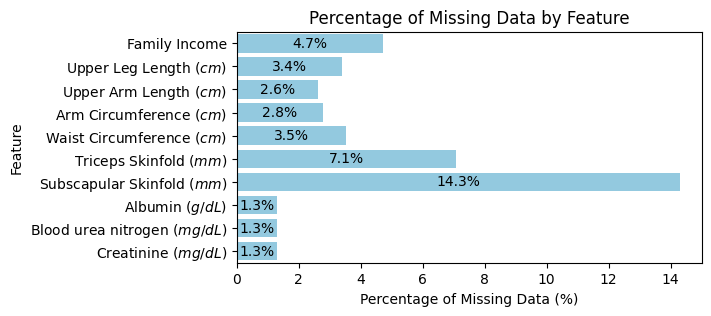

In [16]:
# Filter the data for only columns that contain missing values
columns_with_na = preprocessed_df.columns[preprocessed_df.isna().any()].to_list()
rows_with_na = preprocessed_df[columns_with_na].copy()
percentage_na = rows_with_na.isna().mean() * 100

# Plot Proportion of Missing Data by Feature
plt.figure(figsize=(6, 3))
xlabel = "Percentage of Missing Data (%)"
ylabel = "Feature"
plot_df = percentage_na.reset_index().rename(columns={0: xlabel, "index": ylabel})
ax = sns.barplot(y=ylabel, x=xlabel, data=plot_df, color="skyblue")
add_annotations_to_bars(ax=ax, x_shift=0)

title = "Percentage of Missing Data by Feature"
plt.title(title)
plt.xticks()
save_plot(folder_path, title)
plt.show()

**Observations:**

1. **Respondent Sequence Number, Sex, Age, Race/Ethnicity, Family Income, On Insulin or Diabetes Medications, Weight, Standing Height, Body Mass Index, and Glycohemoglobin:** These columns have **no missing data**.

2. **Albumin, Blood Urea Nitrogen, Creatinine, Family Income, Upper Leg Length, Upper Arm Length, Arm Circumference, and Waist Circumference:** These features have **less than 5% of missing values**. Imputation or removal may be considered based on the significance of these features.

3. **Triceps Skinfold, Subscapular Skinfold:** These features have a higher percentage of missing data (**7.1%** and **14.3%**, respectively). Careful consideration is needed, as **a substantial portion of the data is missing**.


### Check if Missingness is Random

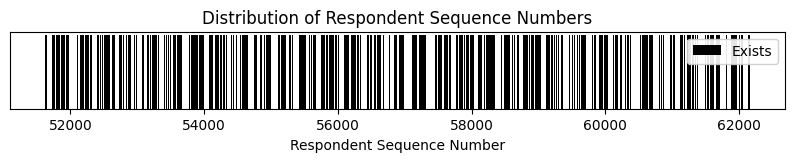

In [17]:
unique_identifier = config.get("unique_identifier")
seqn_range = range(preprocessed_df.index.min(), preprocessed_df.index.max() + 1)
plt.figure(figsize=(10, 1))
plt.bar(seqn_range, color=["black" if number in preprocessed_df.index.values else "w" for number in seqn_range], height=1)
plt.legend(["Exists"], loc="upper right", framealpha=0.9)
plt.xlabel(unique_identifier.title())
title = f'Distribution of {unique_identifier.title()}s'
plt.title(title)
plt.yticks([])  # Hide y-axis
save_plot(folder_path, title)
plt.show()

The distribution of unique identifiers appears to be evenly spread across the entire range, with no apparent clustering or accumulation of identifiers in specific regions. This uniform distribution is a positive sign, indicating a balanced allocation of identifiers without any bias or concentration.

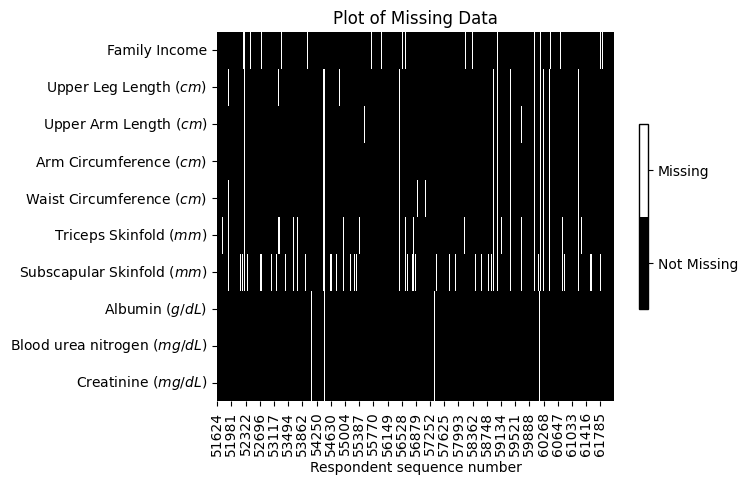

In [18]:
# Plot of Missing Data
colors = ["black", "w"] 
cmap = LinearSegmentedColormap.from_list("Custom", colors, len(colors))
ax = sns.heatmap(rows_with_na.isna().T, cmap=cmap, cbar_kws={"shrink": .5})
colorbar = ax.collections[0].colorbar; colorbar.set_ticks([0.25,0.75])
colorbar.set_ticklabels(["Not Missing", "Missing"])
colorbar.outline.set_edgecolor("black"); colorbar.outline.set_linewidth(1)
title = "Plot of Missing Data"
plt.title(title)
save_plot(folder_path, title)
plt.show()

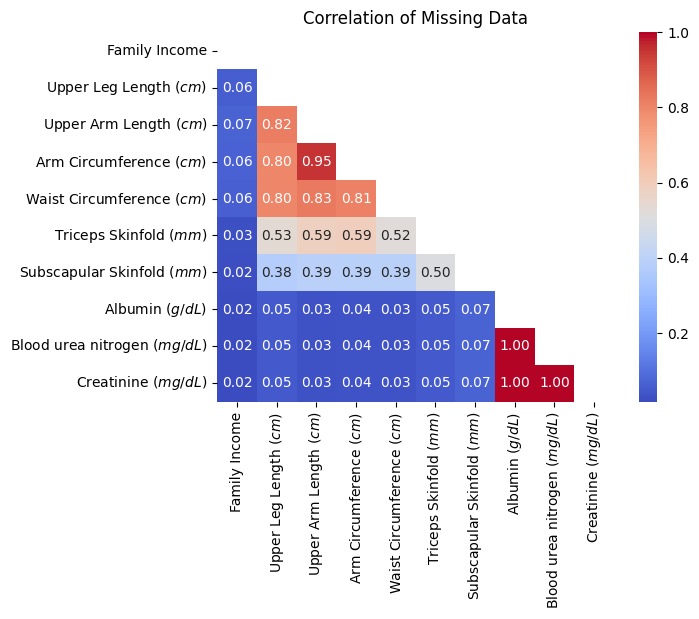

In [19]:
# Correlation of Missing Data

plot_heatmap(
    df=rows_with_na.isna().corr(),
    title="Correlation of Missing Data",
    num_dp=2
)

Observations:
1. Family Income has a relatively low correlation with other features, indicating its missingness may be independent of other variables.
2. Upper Leg Length and Upper Arm Length show a high positive correlation, indicating similar patterns of missingness.
3. Triceps Skinfold and Subscapular Skinfold exhibit a moderate positive correlation, suggesting some shared missingness patterns.
4. The variables Albumin, Blood Urea Nitrogen, and Creatinine have perfect positive correlations, indicating identical missingness patterns.


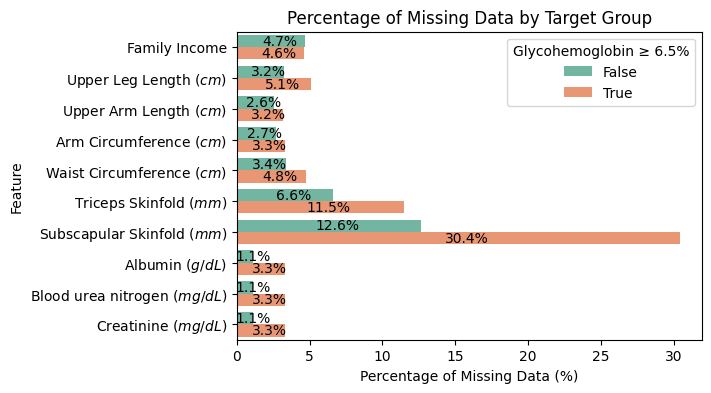

In [20]:
# Proportion of Missing Data by Target Group
target = config.get("target")
feature = config.get("feature")
rows_with_na_and_feat = preprocessed_df[columns_with_na + [feature]].copy()
rows_with_na_and_feat = create_target_variable(rows_with_na_and_feat, config)
percentage_na_by_target = rows_with_na_and_feat.drop(
    columns=[target, feature]
).groupby(rows_with_na_and_feat[target]).apply(lambda x: x.isna().mean()*100).T

# Plot Proportion of Missing Data by Target Group
plt.figure(figsize=(6, 4))
xlabel = "Percentage of Missing Data (%)"
plot_df = percentage_na_by_target.reset_index().melt(id_vars="index", var_name=target, value_name=xlabel)
colors = sns.color_palette("Set2", n_colors=2)
ax = sns.barplot(y="index", x=xlabel, hue=target, data=plot_df, palette=colors)

add_annotations_to_bars(ax=ax, x_shift=6)

title = "Percentage of Missing Data by Target Group"
plt.title(title)
plt.ylabel("Feature")
plt.legend(title=target)
plt.xticks()
save_plot(folder_path, title)
plt.show()

Some features, such as "Triceps Skinfold" and "Subscapular Skinfold," exhibit higher percentages of missing data in the target group with glycohemoglobin levels greater than or equal to 6.5%.<br>
This suggests potential systematic patterns in missing data concerning the target.

## Process Data

In [21]:
processed_df = preprocessed_df.copy()

### Check if Categorical Features can be Encoded

In [22]:
categorical_columns = cleaned_metadata_df["Labels"][cleaned_metadata_df["Levels"].notna()]
cleaned_metadata_df[["Labels", "Levels"]][cleaned_metadata_df["Labels"].isin(categorical_columns)]

,Labels,Levels
Name,,
sex,Sex,2.0
re,Race/Ethnicity,5.0
income,Family Income,14.0
tx,On Insulin or Diabetes Meds,2.0
dx,Diagnosed with DM or Pre-DM,2.0


In [23]:
for categorical_column in categorical_columns:
    print(processed_df[categorical_column].value_counts())
    print()

Sex
female    3423
male      3372
Name: count, dtype: int64

Race/Ethnicity
Non-Hispanic White                   3117
Mexican American                     1366
Non-Hispanic Black                   1217
Other Hispanic                        706
Other Race Including Multi-Racial     389
Name: count, dtype: int64

Family Income
>= 100000         877
[25000,35000)     845
[35000,45000)     610
[75000,100000)    564
[20000,25000)     563
[10000,15000)     531
[45000,55000)     522
[15000,20000)     456
[55000,65000)     376
[5000,10000)      315
[65000,75000)     274
[0,5000)          235
> 20000           232
< 20000            75
Name: count, dtype: int64

On Insulin or Diabetes Meds
0    6171
1     624
Name: count, dtype: int64

Diagnosed with DM or Pre-DM
0    5881
1     914
Name: count, dtype: int64



All the categorical features are binary except for "Sex", "Race/Ethnicity" and "Family Income".<br>
"Sex" can be **converted to binary**.<br>
"Family Income" can be **converted into lower and upper bounds**.<br>
"Race/Ethnicity" is a **nominal feature** that can be **one-hot encoded** for modelling.

### Convert Range Column(s) to Minimum and Maximum Possible Values

In [24]:
processed_df = convert_range_to_min_max(processed_df, config, drop_column=False)
processed_df[[
    config.get("range_column"),
    f'Minimum {config.get("range_column")}',
    f'Maximum {config.get("range_column")}'
]].value_counts(dropna=False)

Family Income   Minimum Family Income  Maximum Family Income
>= 100000       100000.0               NaN                      877
[25000,35000)   25000.0                35000.0                  845
[35000,45000)   35000.0                45000.0                  610
[75000,100000)  75000.0                100000.0                 564
[20000,25000)   20000.0                25000.0                  563
[10000,15000)   10000.0                15000.0                  531
[45000,55000)   45000.0                55000.0                  522
[15000,20000)   15000.0                20000.0                  456
[55000,65000)   55000.0                65000.0                  376
NaN             NaN                    NaN                      320
[5000,10000)    5000.0                 10000.0                  315
[65000,75000)   65000.0                75000.0                  274
[0,5000)        0.0                    5000.0                   235
> 20000         20000.0                NaN             

### Convert Features to Boolean Where Applicable

For modelling, features like "Sex" which contain only two unique values should be converted to binary indicator variables, like so:

In [25]:
binary_features = cleaned_metadata_df["Labels"][cleaned_metadata_df["Levels"]==2]
processed_df[binary_features]

,Sex,On Insulin or Diabetes Meds,Diagnosed with DM or Pre-DM
Respondent sequence number,,,
51624,male,0,0
51626,male,0,0
51628,female,1,1
51629,male,0,0
51630,female,0,0
...,...,...,...
62155,male,0,0
62156,female,0,1
62157,male,0,0


In [26]:
convert_columns_to_boolean(processed_df[binary_features])

,On Insulin or Diabetes Meds,Diagnosed with DM or Pre-DM,Is Male
Respondent sequence number,,,
51624,0,0,True
51626,0,0,True
51628,1,1,False
51629,0,0,True
51630,0,0,False
...,...,...,...
62155,0,0,True
62156,0,1,False
62157,0,0,True


In [27]:
processed_df = convert_columns_to_boolean(processed_df)

In [28]:
processed_df.drop(columns=[config.get("range_column")], inplace=True)

### One-Hot Encode Nominal Features

In [29]:
nominal_features = processed_df.select_dtypes("object").columns
processed_df[nominal_features]

,Race/Ethnicity
Respondent sequence number,
51624,Non-Hispanic White
51626,Non-Hispanic Black
51628,Non-Hispanic Black
51629,Mexican American
51630,Non-Hispanic White
...,...
62155,Mexican American
62156,Non-Hispanic White
62157,Other Hispanic


In [30]:
one_hot_encode_columns(processed_df[nominal_features], drop_columns=False)

,Race/Ethnicity,Mexican American,Non-Hispanic Black,Non-Hispanic White,Other Hispanic,Other Race Including Multi-Racial
Respondent sequence number,,,,,,
51624,Non-Hispanic White,False,False,True,False,False
51626,Non-Hispanic Black,False,True,False,False,False
51628,Non-Hispanic Black,False,True,False,False,False
51629,Mexican American,True,False,False,False,False
51630,Non-Hispanic White,False,False,True,False,False
...,...,...,...,...,...,...
62155,Mexican American,True,False,False,False,False
62156,Non-Hispanic White,False,False,True,False,False
62157,Other Hispanic,False,False,False,True,False


In [31]:
processed_df = one_hot_encode_columns(processed_df, drop_columns=False)

### Create Target Variable

In [32]:
# Create the target variable indicating whether gh >= 6.5
processed_df = create_target_variable(processed_df, config)

In [33]:
processed_df

,Respondent sequence number,Age ($years$),Race/Ethnicity,On Insulin or Diabetes Meds,Diagnosed with DM or Pre-DM,Weight ($kg$),Standing Height ($cm$),Body Mass Index ($kg/m^2$),Upper Leg Length ($cm$),Upper Arm Length ($cm$),...,Creatinine ($mg/dL$),Minimum Family Income,Maximum Family Income,Is Male,Mexican American,Non-Hispanic Black,Non-Hispanic White,Other Hispanic,Other Race Including Multi-Racial,Glycohemoglobin ≥ 6.5%
Respondent sequence number,,,,,,,,,,,,,,,,,,,,,
51624,51624,34.166667,Non-Hispanic White,0,0,87.4,164.7,32.22,41.5,40.0,...,0.94,25000.0,35000.0,True,False,False,True,False,False,False
51626,51626,16.833333,Non-Hispanic Black,0,0,72.3,181.3,22.00,42.0,39.5,...,0.89,45000.0,55000.0,True,False,True,False,False,False,False
51628,51628,60.166667,Non-Hispanic Black,1,1,116.8,166.0,42.39,35.3,39.0,...,1.11,10000.0,15000.0,False,False,True,False,False,False,False
51629,51629,26.083333,Mexican American,0,0,97.6,173.0,32.61,41.7,38.7,...,0.80,25000.0,35000.0,True,True,False,False,False,False,False
51630,51630,49.666667,Non-Hispanic White,0,0,86.7,168.4,30.57,37.5,36.1,...,0.79,35000.0,45000.0,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62155,62155,33.000000,Mexican American,0,0,94.3,163.5,35.28,34.4,34.7,...,0.97,35000.0,45000.0,True,True,False,False,False,False,False
62156,62156,48.916667,Non-Hispanic White,0,1,87.1,156.9,35.38,33.9,34.5,...,0.89,0.0,5000.0,False,False,False,True,False,False,False
62157,62157,27.500000,Other Hispanic,0,0,57.0,164.3,21.12,35.3,33.7,...,0.94,35000.0,45000.0,True,False,False,False,True,False,False
